In [33]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm import tqdm
from datetime import datetime
import argparse

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
seed=42

device: cuda:0


### 作者自己提供的重建图像

In [3]:
import os
from PIL import Image
import torch
import numpy as np

# Define the source and target directories
source_dir = '/home/tom/fsas/eeg_data/generated_images/clip_old'
target_dir = '/home/tom/fsas/eeg_data/features/generated_images_tensors/clip_old'

# Create the target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

subdirs = sorted(
    [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))],
    key=lambda x: x.lower()  # 提取5位数字前缀转换为整数[2,3](@ref)
)
# Initialize a list to hold all the image tensors
tensor_list = []

for subdir in subdirs:
    subdir_path = os.path.join(source_dir, subdir)
    
    image_files = sorted(
        [f for f in os.listdir(subdir_path) 
         if f.lower().endswith(('.png', '.jpg', '.jpeg')) and  # 过滤图片
         f.split('.')[0].isdigit()],  # 验证数字命名格式
        key=lambda x: int(x.split('.')[0])  # 按数字升序排列
    )
        
    image_path = os.path.join(subdir_path, image_files[0])
    print(f"image path: {image_path}")
    
    with Image.open(image_path) as img:
        # Convert the image to a PyTorch tensor and add a batch dimension
        img = img.resize((256, 256), Image.BILINEAR)
        img = img.convert('RGB')
        tensor = torch.tensor(np.array(img)).float() / 255.0
        tensor = tensor.permute(2, 0, 1).unsqueeze(0)
        tensor_list.append(tensor)

# Concatenate all tensors along the 0th dimension
all_tensors = torch.cat(tensor_list, dim=0)

# Save the combined tensor
combined_tensor_path = os.path.join(target_dir, "generated_images_clip_old.pt")
print(f"test tensor shape: {all_tensors.shape}")
torch.save(all_tensors, combined_tensor_path)

image path: /home/tom/fsas/eeg_data/generated_images/clip_old/aircraft_carrier/0.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_old/antelope/0.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_old/backscratcher/0.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_old/balance_beam/0.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_old/banana/0.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_old/baseball_bat/0.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_old/basil/0.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_old/basketball/0.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_old/bassoon/0.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_old/baton4/0.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_old/batter/0.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_old/beaver/0.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_old/ben

### 纯CLIP生成

In [20]:
import os
from PIL import Image
import torch
import numpy as np

# Define the source and target directories
source_dir = '/home/tom/fsas/eeg_data/generated_images/clip'
target_dir = '/home/tom/fsas/eeg_data/features/generated_images_tensors/clip'

# Create the target directory if it doesn't exis
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

file_list = sorted(
    [f for f in os.listdir(source_dir) if f.endswith('.png')],
    key=lambda x: int(x.split('.')[0])  # 提取文件名中的数字进行排序
)

# Initialize a list to hold all the image tensors
tensor_list = []

# Iterate over the folders in the source directory
for image_name in file_list:
    image_path = os.path.join(source_dir, image_name)
    print(f"image path: {image_path}") 
    with Image.open(image_path) as img:
        # Convert the image to a PyTorch tensor and add a batch dimension
        img = img.resize((256, 256), Image.BILINEAR)
        img = img.convert('RGB')
        tensor = torch.tensor(np.array(img)).float() / 255.0
        tensor = tensor.permute(2, 0, 1).unsqueeze(0)
        tensor_list.append(tensor)

# Concatenate all tensors along the 0th dimension
all_tensors = torch.cat(tensor_list, dim=0)
print(f"all_tensors shape: {all_tensors.shape}")


# Save the combined tensor
combined_tensor_path = os.path.join(target_dir, "generated_images_clip.pt")
torch.save(all_tensors, combined_tensor_path)

image path: /home/tom/fsas/eeg_data/generated_images/clip/0.png
image path: /home/tom/fsas/eeg_data/generated_images/clip/1.png
image path: /home/tom/fsas/eeg_data/generated_images/clip/2.png
image path: /home/tom/fsas/eeg_data/generated_images/clip/3.png
image path: /home/tom/fsas/eeg_data/generated_images/clip/4.png
image path: /home/tom/fsas/eeg_data/generated_images/clip/5.png
image path: /home/tom/fsas/eeg_data/generated_images/clip/6.png
image path: /home/tom/fsas/eeg_data/generated_images/clip/7.png
image path: /home/tom/fsas/eeg_data/generated_images/clip/8.png
image path: /home/tom/fsas/eeg_data/generated_images/clip/9.png
image path: /home/tom/fsas/eeg_data/generated_images/clip/10.png
image path: /home/tom/fsas/eeg_data/generated_images/clip/11.png
image path: /home/tom/fsas/eeg_data/generated_images/clip/12.png
image path: /home/tom/fsas/eeg_data/generated_images/clip/13.png
image path: /home/tom/fsas/eeg_data/generated_images/clip/14.png
image path: /home/tom/fsas/eeg_data

### CLIP + low level生成的图像

In [35]:
import os
from PIL import Image
import torch
import numpy as np

# Define the source and target directories
source_dir = '/home/tom/fsas/eeg_data/generated_images/clip_low-level'
target_dir = '/home/tom/fsas/eeg_data/features/generated_images_tensors/clip_low-level'

# Create the target directory if it doesn't exis
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

file_list = sorted(
    [f for f in os.listdir(source_dir) if f.endswith('.png')],
    key=lambda x: int(x.split('.')[0])  # 提取文件名中的数字进行排序
)

# Initialize a list to hold all the image tensors
tensor_list = []

# Iterate over the folders in the source directory
for image_name in file_list:
    image_path = os.path.join(source_dir, image_name)
    print(f"image path: {image_path}") 
    with Image.open(image_path) as img:
        # Convert the image to a PyTorch tensor and add a batch dimension
        img = img.resize((256, 256), Image.BILINEAR)
        img = img.convert('RGB')
        tensor = torch.tensor(np.array(img)).float() / 255.0
        tensor = tensor.permute(2, 0, 1).unsqueeze(0)
        tensor_list.append(tensor)

# Concatenate all tensors along the 0th dimension
all_tensors = torch.cat(tensor_list, dim=0)
print(f"all_tensors shape: {all_tensors.shape}")


# Save the combined tensor
combined_tensor_path = os.path.join(target_dir, "generated_images_clip_low_level.pt")
torch.save(all_tensors, combined_tensor_path)

image path: /home/tom/fsas/eeg_data/generated_images/clip_low-level/0.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_low-level/1.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_low-level/2.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_low-level/3.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_low-level/4.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_low-level/5.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_low-level/6.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_low-level/7.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_low-level/8.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_low-level/9.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_low-level/10.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_low-level/11.png
image path: /home/tom/fsas/eeg_data/generated_images/clip_low-level/12.png
image path: /home/tom/fsas/eeg_data

In [36]:
import os
from PIL import Image
import torch
import numpy as np

# Define the source and target directories
source_dir = '/home/tom/fsas/eeg_data/images/test_images'
target_dir = '/home/tom/fsas/eeg_data/features/test_images_tensors'

# Create the target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

subdirs = sorted(
    [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))],
    key=lambda x: int(x.split('_')[0])  # 提取5位数字前缀转换为整数[2,3](@ref)
)
# Initialize a list to hold all the image tensors
tensor_list = []

for subdir in subdirs:
    subdir_path = os.path.join(source_dir, subdir)

    image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_path = os.path.join(subdir_path, image_files[0])
    print(f"image path: {image_path}")
    
    with Image.open(image_path) as img:
        # Convert the image to a PyTorch tensor and add a batch dimension
        img = img.resize((256, 256), Image.BILINEAR)
        img = img.convert('RGB')
        tensor = torch.tensor(np.array(img)).float() / 255.0
        tensor = tensor.permute(2, 0, 1).unsqueeze(0)
        tensor_list.append(tensor)

# Concatenate all tensors along the 0th dimension
all_tensors = torch.cat(tensor_list, dim=0)

# Save the combined tensor
combined_tensor_path = os.path.join(target_dir, "test_images.pt")
print(f"test tensor shape: {all_tensors.shape}")
torch.save(all_tensors, combined_tensor_path)

image path: /home/tom/fsas/eeg_data/images/test_images/00001_aircraft_carrier/aircraft_carrier_06s.jpg
image path: /home/tom/fsas/eeg_data/images/test_images/00002_antelope/antelope_01b.jpg
image path: /home/tom/fsas/eeg_data/images/test_images/00003_backscratcher/backscratcher_01b.jpg
image path: /home/tom/fsas/eeg_data/images/test_images/00004_balance_beam/balance_beam_04s.jpg
image path: /home/tom/fsas/eeg_data/images/test_images/00005_banana/banana_09s.jpg
image path: /home/tom/fsas/eeg_data/images/test_images/00006_baseball_bat/baseball_bat_10s.jpg
image path: /home/tom/fsas/eeg_data/images/test_images/00007_basil/basil_05s.jpg
image path: /home/tom/fsas/eeg_data/images/test_images/00008_basketball/basketball_05s.jpg
image path: /home/tom/fsas/eeg_data/images/test_images/00009_bassoon/bassoon_01b.jpg
image path: /home/tom/fsas/eeg_data/images/test_images/00010_baton4/baton4_05s.jpg
image path: /home/tom/fsas/eeg_data/images/test_images/00011_batter/batter_01b.jpg
image path: /home

# Configurations

In [37]:
recon_path = '/home/tom/fsas/eeg_data/features/generated_images_tensors/clip_low-level/generated_images_clip_low_level.pt'
# recon_path = '/home/tom/fsas/eeg_data/features/generated_images_tensors/clip_old/generated_images_clip_old.pt'
all_images_path = '/home/tom/fsas/eeg_data/features/test_images_tensors/test_images.pt'
all_brain_recons = torch.load(f'{recon_path}')
all_images = torch.load(f'{all_images_path}')


all_images = all_images.to(device)
all_brain_recons = all_brain_recons.to(device)

print(f"all_images dtype: {all_images.dtype}")
print(f"all_brain_recons dtype: {all_brain_recons.dtype}")

/tmp/ipykernel_576/2034998527.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_brain_recons = torch.load(f'{recon_path}')
/tmp/ipykernel_576/2034998527.py:5: FutureWa

all_images dtype: torch.float32
all_brain_recons dtype: torch.float32


# Display reconstructions next to ground truth images

all_images shape: torch.Size([200, 3, 256, 256])
all_brain_recons shape: torch.Size([200, 3, 256, 256])


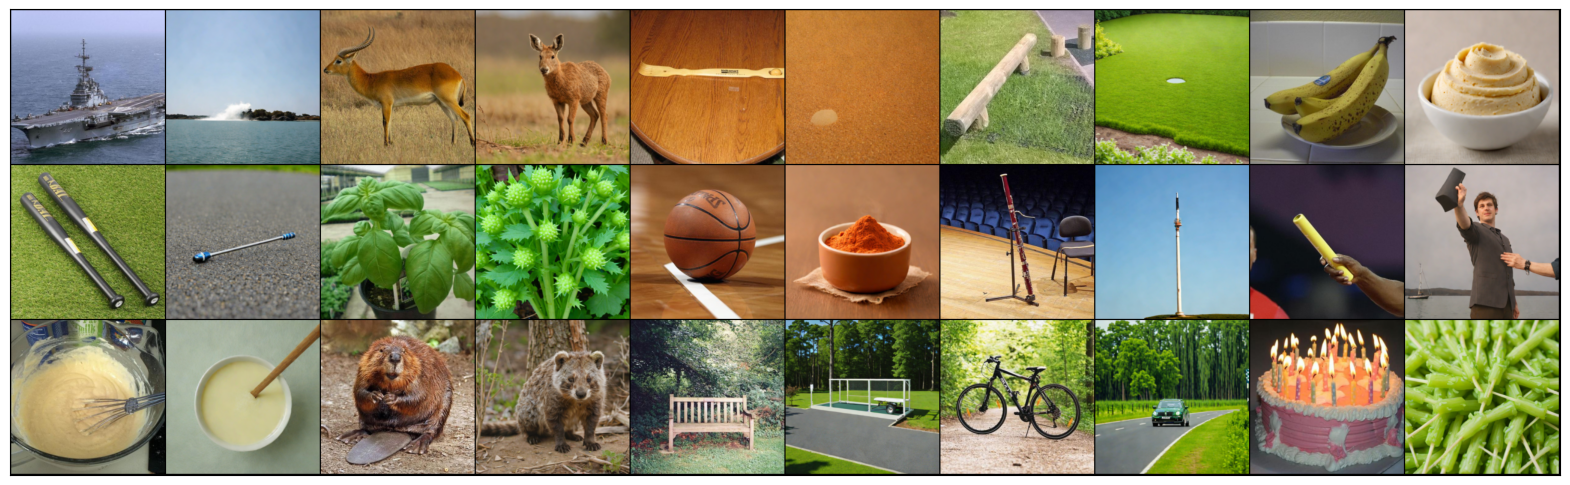

In [38]:
# all_images = all_images.permute(0, 3, 1, 2).contiguous().float() 
# all_brain_recons = all_brain_recons.permute(0, 3, 1, 2).contiguous().float()

print(f"all_images shape: {all_images.shape}") # [200, 256, 256, 3]
print(f"all_brain_recons shape: {all_brain_recons.shape}") #[200, 256, 256, 3]

np.random.seed(0)
ind = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

all_interleaved = torch.zeros(len(ind)*2, 3,256, 256)
icount = 0
for t in ind:
    all_interleaved[icount] = all_images[t]
    all_interleaved[icount+1] = all_brain_recons[t]
    icount += 2

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs,figsize):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.ToPILImage()(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
grid = make_grid(all_interleaved, nrow=10, padding=2)
show(grid,figsize=(20,16))

# 2-Way Identification

In [39]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

@torch.no_grad()
def two_way_identification(all_brain_recons, all_images, model, preprocess, feature_layer=None, return_avg=True):
    preds = model(torch.stack([preprocess(recon) for recon in all_brain_recons], dim=0).to(device))
    reals = model(torch.stack([preprocess(indiv) for indiv in all_images], dim=0).to(device))
    if feature_layer is None:
        preds = preds.float().flatten(1).cpu().numpy()
        reals = reals.float().flatten(1).cpu().numpy()
    else:
        preds = preds[feature_layer].float().flatten(1).cpu().numpy()
        reals = reals[feature_layer].float().flatten(1).cpu().numpy()

    r = np.corrcoef(reals, preds)
    r = r[:len(all_images), len(all_images):]
    congruents = np.diag(r)

    success = r < congruents
    success_cnt = np.sum(success, 0)

    if return_avg:
        perf = np.mean(success_cnt) / (len(all_images)-1)
        return perf
    else:
        return success_cnt, len(all_images)-1

## PixCorr

In [40]:
preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR),
])

# Flatten images while keeping the batch dimension
all_images_flattened = preprocess(all_images).reshape(len(all_images), -1).cpu()
all_brain_recons_flattened = preprocess(all_brain_recons).view(len(all_brain_recons), -1).cpu()

print(all_images_flattened.shape)
print(all_brain_recons_flattened.shape)

corrsum = 0
for i in tqdm(range(200)):
    corrsum += np.corrcoef(all_images_flattened[i], all_brain_recons_flattened[i])[0][1]
corrmean = corrsum /200 

pixcorr = corrmean
print(pixcorr)

torch.Size([200, 541875])
torch.Size([200, 541875])


100%|██████████| 200/200 [00:01<00:00, 167.61it/s]

0.19842447002326918


## SSIM

In [41]:
# see https://github.com/zijin-gu/meshconv-decoding/issues/3
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim

preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR), 
])

# convert image to grayscale with rgb2grey
img_gray = rgb2gray(preprocess(all_images).permute((0,2,3,1)).cpu())
recon_gray = rgb2gray(preprocess(all_brain_recons).permute((0,2,3,1)).cpu())
print("converted, now calculating ssim...")

ssim_score=[]
for im,rec in tqdm(zip(img_gray,recon_gray),total=len(all_images)):
    ssim_score.append(ssim(rec, im, multichannel=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=1.0))

ssim = np.mean(ssim_score)
print(ssim)

converted, now calculating ssim...


100%|██████████| 200/200 [00:02<00:00, 94.41it/s]

0.4222911017528456


### AlexNet

In [42]:
from torchvision.models import alexnet, AlexNet_Weights
alex_weights = AlexNet_Weights.IMAGENET1K_V1

alex_model = create_feature_extractor(alexnet(weights=alex_weights), return_nodes=['features.4','features.11']).to(device)
alex_model.eval().requires_grad_(False)

# see alex_weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

layer = 'early, AlexNet(2)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_brain_recons.to(device).float(), all_images, 
                                                          alex_model, preprocess, 'features.4')
alexnet2 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet2:.4f}")

layer = 'mid, AlexNet(5)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_brain_recons.to(device).float(), all_images, 
                                                          alex_model, preprocess, 'features.11')
alexnet5 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet5:.4f}")


---early, AlexNet(2)---
2-way Percent Correct: 0.8197

---mid, AlexNet(5)---
2-way Percent Correct: 0.8791


### InceptionV3

In [43]:
from torchvision.models import inception_v3, Inception_V3_Weights
weights = Inception_V3_Weights.DEFAULT
inception_model = create_feature_extractor(inception_v3(weights=weights), 
                                           return_nodes=['avgpool']).to(device)
inception_model.eval().requires_grad_(False)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(342, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

all_per_correct = two_way_identification(all_brain_recons, all_images,
                                        inception_model, preprocess, 'avgpool')
        
inception = np.mean(all_per_correct)
print(f"2-way Percent Correct: {inception:.4f}")

/opt/conda/envs/BCI/lib/python3.11/site-packages/torchvision/models/feature_extraction.py:174: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


2-way Percent Correct: 0.7224


### CLIP

In [44]:
import clip
clip_model, preprocess = clip.load("ViT-L/14", device=device)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])

all_per_correct = two_way_identification(all_brain_recons, all_images,
                                        clip_model.encode_image, preprocess, None) # final layer
clip_ = np.mean(all_per_correct)
print(f"2-way Percent Correct: {clip_:.4f}")

2-way Percent Correct: 0.7766


### Efficient Net

In [45]:
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
weights = EfficientNet_B1_Weights.DEFAULT
eff_model = create_feature_extractor(efficientnet_b1(weights=weights), 
                                    return_nodes=['avgpool']).to(device)
eff_model.eval().requires_grad_(False)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(255, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

gt = eff_model(preprocess(all_images))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = eff_model(preprocess(all_brain_recons))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

effnet = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
print("Distance:",effnet)

Distance: 0.8751785582517358


### SwAV

In [46]:
swav_model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
swav_model = create_feature_extractor(swav_model, 
                                    return_nodes=['avgpool']).to(device)
swav_model.eval().requires_grad_(False)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

gt = swav_model(preprocess(all_images))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = swav_model(preprocess(all_brain_recons))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

swav = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
print("Distance:",swav)

Using cache found in /home/tom/.cache/torch/hub/facebookresearch_swav_main
/opt/conda/envs/BCI/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/BCI/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Distance: 0.5632383083590012


# Display in table

In [47]:
# Create a dictionary to store variable names and their corresponding values
data = {
    "Metric": ["PixCorr", "SSIM", "AlexNet(2)", "AlexNet(5)", "InceptionV3", "CLIP", "EffNet-B", "SwAV"],
    "Value": [pixcorr, ssim, alexnet2, alexnet5, inception, clip_, effnet, swav],
}

df = pd.DataFrame(data)
print(df.to_string(index=False))

# if not utils.is_interactive():
    # # save table to txt file
    # df.to_csv(f'{recon_path[:-3]}.csv', sep='\t', index=False)

     Metric    Value
    PixCorr 0.198424
       SSIM 0.422291
 AlexNet(2) 0.819673
 AlexNet(5) 0.879070
InceptionV3 0.722362
       CLIP 0.776558
   EffNet-B 0.875179
       SwAV 0.563238
